# Initialization

## Import

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import random_split
    
import torchvision.transforms.functional as tF

from models.vgg16 import VGGUNET16

from dataset.dataset import seg_datasets

from utils.dataloader_utils import get_loader
from utils.save_load_utils import save_model, load_model
from utils.evaluation_utils import calculate_miou, check_acc
from utils.visualization_utils import save_pred_masks, visualize_segmentation, plot_segmentation
                                                                     
import albumentations as A

from torch.utils.tensorboard import SummaryWriter

%matplotlib inline
import os
import time
import random
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = False

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


## Hyperparameters

In [2]:
hyperparameters = {
    'test_dir' : './images/test',
    'train_dir' : './images/train',
    'seed' : 9999,
    'dataloader' :{
        'batch_size' : 8,
        'num_workers' : 4,
        'pin_memory' : False, 
    },
    'optimizer' :{
        'lr' : 1e-4,
        'betas' : (0.9, 0.999),
        'weight_decay' : 1e-4,
    },
    'epochs' : 150,
    'training_size' : 0,
    'test_size': 0,
    'gradient_clipping' : 1.0,
    'vggunet': {
        'in_channels': 3,
        'out_channels': 1,
        'features': 64,
        'height': 320,
        'width': 320,
        'pre_trained_path': 'checkpoints/pretrained/pretrained_best.pth.tar',
    }, 
    'output_dir':{
        'results':'../generated_examples/vggunet16/',
        'model1':'../generated_examples/vggunet16/wc/',
        'model2':'../generated_examples/vggunet16/kd/',
    },
    'checkpoints_dir':{
        'model1': './checkpoints/vggunet16/wc/',
        'model2': './checkpoints/vggunet16/kd/',
    },
}

## Seed Everything

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(hyperparameters['seed'])

#  Data Preprocessing

## Data Augmentation

In [4]:
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(512, 512),
])

test_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    A.Resize(512, 512),
])

"""
test_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize(512, antialias=True)
])
"""
train_transforms, test_transforms

(Compose([
   HorizontalFlip(always_apply=False, p=0.5),
   VerticalFlip(always_apply=False, p=0.5),
   Rotate(always_apply=False, p=0.5, limit=(-90, 90), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box', crop_border=False),
   Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
   Resize(always_apply=False, p=1, height=512, width=512, interpolation=1),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True),
 Compose([
   Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
   Resize(always_apply=False, p=1, height=512, width=512, interpolation=1),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True))

## Dataset

In [5]:
train_dataset = seg_datasets(hyperparameters['train_dir'], train_transforms)
test_dataset = seg_datasets(hyperparameters['test_dir'], test_transforms)

len(train_dataset), len(test_dataset)

(104, 27)

In [6]:
print(test_dataset.img_files)

['115_Plan.jpg', '119_Plan.jpg', '122_Plan.jpg', '125_Plan.jpg', '126_Plan.jpg', '131_Plan.jpg', '16_Plan.jpg', '17_Plan.jpg', '21_Plan.jpg', '26_Plan.jpg', '40_Plan.jpg', '41_Plan.jpg', '48_Plan.jpg', '4_Plan.jpg', '57_Plan.jpg', '58_Plan.jpg', '63_Plan.jpg', '66_Plan.jpg', '6_Plan.jpg', '73_Plan.jpg', '81_Plan.jpg', '88_Plan.jpg', '8_Plan.jpg', '92_Plan.jpg', '95_Plan.jpg', '98_Plan.jpg', '99_Plan.jpg']


In [7]:
hyperparameters['training_size'] = len(train_dataset)
hyperparameters['test_size'] = len(test_dataset)

In [8]:
sample = train_dataset[30]
torch.unique(sample[1])

tensor([0., 1., 2., 3.])

In [9]:
img, mask = train_dataset[20]
img.shape, mask.shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


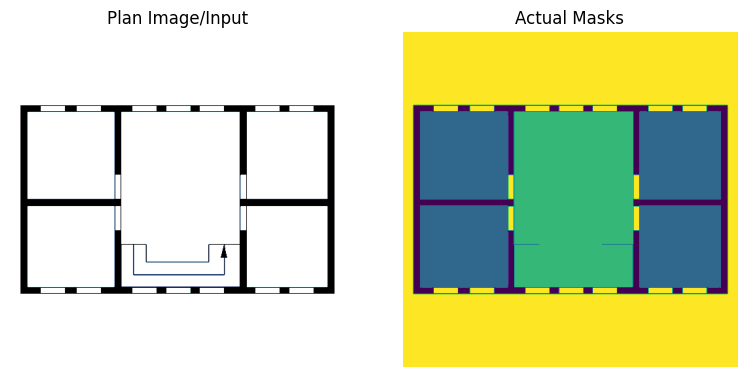

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout()
ax1.axis('off')
ax1.set_title('Plan Image/Input')
ax1.imshow(img.permute(1, 2, 0).numpy())
    
ax2.axis('off')
ax2.set_title('Actual Masks')
ax2.imshow(mask.numpy().transpose(1,2,0))

## Color Mapping

In [11]:
color_mapping = {
    0: (0, 0, 0),         # Walls
    1: (255, 80, 80),     # Iwan
    2: (80, 80, 255),     # Room
    3: (255, 255, 255),   # Background
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

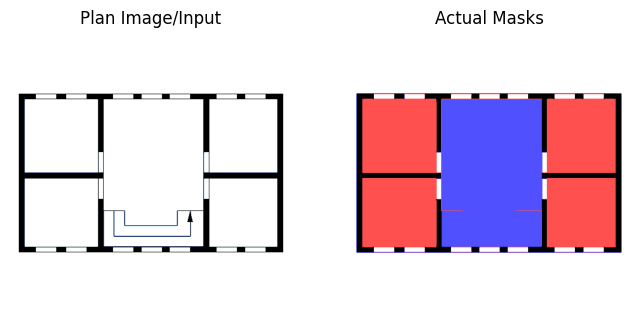

In [12]:
visualization = visualize_segmentation(mask, color_mapping, from_tensor=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

ax1.imshow(img.permute(1, 2, 0).numpy())
ax1.set_title('Plan Image/Input')
ax1.axis('off')

ax2.imshow(visualization)
ax2.set_title('Actual Masks')
ax2.axis('off')

## Dataloader

In [13]:
train_dataloader, test_dataloader = get_loader(
    train_dir = hyperparameters['train_dir'],
    test_dir = hyperparameters['test_dir'],
    batch_size = hyperparameters['dataloader']['batch_size'],
    train_transform = train_transforms,
    test_transform = test_transforms,
    num_workers = hyperparameters['dataloader']['num_workers'],
    pin_memory = hyperparameters['dataloader']['pin_memory']
)

len(train_dataloader), len(test_dataloader)

(13, 4)

In [14]:
img_a_batch, img_b_batch = next(iter(train_dataloader))
print(img_a_batch.shape, img_b_batch.shape)
print(img_a_batch.size(0))

torch.Size([8, 3, 512, 512]) torch.Size([8, 1, 512, 512])
8


# Model

## Model Loading

In [15]:
"""
model1 --> weight copy
model2 --> knowledge distillation

"""

model1 = VGGUNET16(
    features = hyperparameters['vggunet']['features'], 
    in_channels=hyperparameters['vggunet']['in_channels'], 
    out_channels=hyperparameters['vggunet']['out_channels']
)

model2 = VGGUNET16(
    features = hyperparameters['vggunet']['features'], 
    in_channels=hyperparameters['vggunet']['in_channels'], 
    out_channels=hyperparameters['vggunet']['out_channels']
)

## Pre-Trained Model Loading

In [16]:
pip install pretrained-backbones-unet

Note: you may need to restart the kernel to use updated packages.


In [17]:
from backbones_unet.model.unet import Unet

"""
pre_model:
    - weight source for model 1
    - teacher model for model 2
    - weight source and teacher model for model 3
"""

pre_model = Unet(
    backbone='convnext_base', # backbone network name
    in_channels=3,            # input channels (1 for gray-scale images, 3 for RGB, etc.)
    num_classes=1,            # output channels (number of classes in your dataset)
)

checkpoint = torch.load(hyperparameters['vggunet']['pre_trained_path'])
pre_model.load_state_dict(checkpoint['model_state_dict'], strict=True)

pre_model.to(device)

C:\Users\user\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unet(
  (encoder): FeatureListNet(
    (stem_0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (stem_1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    (stages_0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_af

In [18]:
from torchvision.models import vgg16, VGG16_Weights

weights = VGG16_Weights.DEFAULT
wc_model = vgg16(weights=weights)

In [19]:
pretrained_dict = pre_model.state_dict()
model1_dict = model1.state_dict()

new_state_dict1 = {}

for k, v in pretrained_dict.items():
    if k in model1_dict:
        new_state_dict1[k] = v

model1_dict.update(new_state_dict1)
model1.load_state_dict(model1_dict)

<All keys matched successfully>

## Number of Parameters

In [20]:
### Dummy Data
__batch_size = 1
__in_channels = hyperparameters['vggunet']['in_channels']
__width = hyperparameters['vggunet']['width']
__height = hyperparameters['vggunet']['height']

dummy_input = torch.randn((__batch_size, __in_channels, __height, __width))
dummy_out = model1(dummy_input)

print(f'Model input size: {dummy_input.shape}')
print(f'Model output size: {dummy_out.shape}')

Model input size: torch.Size([1, 3, 320, 320])
Model output size: torch.Size([1, 1, 320, 320])


In [21]:
print(f'Number of Parameters: {sum(dummy_out.numel() for p in model1.parameters()):,}')

Number of Parameters: 9,011,200


# Loss & Optimizer

## Loss Function

In [22]:
"""
model1 --> loss_fn (segmentation loss)
model2 --> total_loss (segmentation loss + distillation loss)

"""

'\nmodel1 --> loss_fn (segmentation loss)\nmodel2 --> total_loss (segmentation loss + distillation loss)\n\n'

In [23]:
criterion = nn.MSELoss(reduction='none')

def loss_fn(img_input, pred_student, mask, teacher_model, alpha=0.01):
    
    loss_by_pixel = criterion(pred_student, mask)
    loss = loss_by_pixel.mean()
    
    return loss

In [24]:
@torch.no_grad()
def dist_loss(img_input, pred_student, teacher_model):
    teacher_model.eval()
    pred_teacher = teacher_model(img_input)
    distill_loss_by_pixel = criterion(pred_student, pred_teacher)
    loss = distill_loss_by_pixel.mean()
    
    return loss

In [25]:
def total_loss(img_input, pred_student, mask, teacher_model, alpha=0.01):
    segmentation_loss = loss_fn(img_input, pred_student, mask, teacher_model)
    distillation_loss = dist_loss(img_input, pred_student, teacher_model)
    total_loss = segmentation_loss + alpha * distillation_loss
    
    return total_loss

## Optimizer & Scheduler

In [26]:
learning_rate = hyperparameters['optimizer']['lr']
betas = hyperparameters['optimizer']['betas']

optimizer1 = torch.optim.Adam(
    model1.parameters(),
    lr = learning_rate,
    betas = betas, 
)

optimizer2 = torch.optim.Adam(
    model2.parameters(),
    lr = learning_rate,
    betas = betas, 
)

scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min', patience=20, factor=0.1)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', patience=20, factor=0.1)

# Training

## Train Function

In [27]:
def train_fn(
    epoch,
    model,
    dataloader, 
    optimizer, 
    scheduler,
    criterion, 
    device,
    gradient_clipping,
    summary_writer
):
    
    model.train()
    
    compute_avg = lambda x: sum(x) / len(x)
    total_batches = len(dataloader)
    write_interval = total_batches // 4
    
    avg_loss = []
    epochs = hyperparameters['epochs']
    
    with tqdm(total=hyperparameters['training_size'], desc=f'Train/Epoch {epoch}/{epochs}', unit='img') as pbar:
        for idx, (img, mask) in enumerate(dataloader):
            img = img.to(device)
            mask = mask.to(device)

            optimizer.zero_grad()

            pred_mask = model(img)

            loss = criterion(img_input=img, 
                              pred_student=pred_mask, 
                              mask=mask, 
                              teacher_model=pre_model)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
            optimizer.step()

            # Record Results
            avg_loss.append(loss.item())

            """
            # Update Progress Bar
            _avg_loss = compute_avg(avg_loss)
            
            if idx % write_interval == 0:
                summary_writer.add_scalar('Eval/Average Loss', _avg_loss, ((epoch-1)*total_batches) + idx)
            """
            
            pbar.update(img.shape[0])
        
    return compute_avg(avg_loss) 

## Evaluation Function

In [28]:
@torch.no_grad()
def eval_fn(
    epoch,
    model, 
    dataloader, 
    criterion, 
    device,
    color_mapping,
    summary_writer
):
    model.eval()
    
    # Average Loss and mIoU
    avg_loss = []
    avg_mIoU = []
    
    #Accuracy
    total_correct = 0
    total_pixel = 0

    compute_avg = lambda x: sum(x) / len(x)
    total_batches = len(dataloader)
    write_interval = total_batches // 4
    
    epochs = hyperparameters['epochs']
    
    with tqdm(total=hyperparameters['test_size'], desc=f'Eval/Epoch {epoch}/{epochs}', unit='img') as pbar:
        for idx, (img, mask) in enumerate(dataloader):
            img = img.to(device)
            mask = mask.to(device)

            #Accuracy
            num_correct, num_pixel = check_acc(img, mask, model, device)
            total_correct += num_correct
            total_pixel += num_pixel

            pred_mask = model(img)
            loss = criterion(img_input=img, 
                              pred_student=pred_mask, 
                              mask=mask, 
                              teacher_model=pre_model)

            # mIoU
            miou = calculate_miou(pred_mask, mask, color_mapping)

            avg_loss.append(loss.item())
            avg_mIoU.append(miou.item())
            
            """
            # Update Progress Bar
            _avg_loss = compute_avg(avg_loss)
            _avg_miou = compute_avg(avg_mIoU)
            
            if idx % write_interval == 0:
                summary_writer.add_scalar('Eval/Average Loss', _avg_loss, ((epoch-1)*total_batches) + idx)
                summary_writer.add_scalar('Eval/Average mIoU', _avg_miou, ((epoch-1)*total_batches) + idx)
            """  
            
            pbar.update(img.shape[0])

    acc = 100*(num_correct/num_pixel)
    return compute_avg(avg_loss), compute_avg(avg_mIoU), acc

## Start Training

In [29]:
best_model1 = {
    'best_state_dict' : None,
    'best_epoch' : None,
    'best_eval_loss' : None,
    'best_eval_miou' : 0.0,
    'best_eval_acc' : None,
}

best_model2 = {
    'best_state_dict' : None,
    'best_epoch' : None,
    'best_eval_loss' : None,
    'best_eval_miou' : 0.0,
    'best_eval_acc' : None,
}

history = {
    'model1':{
        'train_loss': [],
        'eval_loss' : [],
        'eval_miou' : [],
        'eval_acc' : [],
    },
    'model2':{
        'train_loss': [],
        'eval_loss' : [],
        'eval_miou' : [],
        'eval_acc' : [],
    },
}

In [30]:
def model1_train_start():
    model1.to(device)
    writer = SummaryWriter('runs/vggunet16_model1')
    
    for epoch in range(1, hyperparameters['epochs']+1):  
        
        train_loss = train_fn(
            epoch = epoch,
            model = model1,
            dataloader = train_dataloader, 
            optimizer = optimizer1, 
            scheduler = scheduler1,
            criterion = loss_fn, 
            device = device,
            gradient_clipping = hyperparameters['gradient_clipping'],
            summary_writer = writer,
        )
        
        eval_loss, eval_miou, eval_acc = eval_fn(
            epoch = epoch,
            model = model1, 
            dataloader = test_dataloader, 
            criterion = loss_fn, 
            device = device,
            color_mapping = color_mapping,
            summary_writer = writer,
        )

        print(f""""
        Epoch: {epoch}, 
        Average Train Loss: {train_loss:.4f} |
        Average Test Loss: {eval_loss:.4f} |
        Average Test mIoU: {eval_miou:.2f}
        Average Test Accuracy: {eval_acc}""")
        
        
        #Tensorboard summary writer, saving the epoch results
        writer.add_scalar('Train Loss',train_loss, epoch)
        writer.add_scalar('Eval Loss',eval_loss, epoch)
        writer.add_scalar('Eval mIoU',eval_miou, epoch)
        writer.add_scalar('Eval Accuracy',eval_acc, epoch)
        
        
        history['model1']['train_loss'].append(train_loss)
        history['model1']['eval_loss'].append(eval_loss)
        history['model1']['eval_miou'].append(eval_miou)
        history['model1']['eval_acc'].append(eval_acc)
        
        save_model(
            model=model1, 
            optimizer=optimizer1, 
            root_folder=hyperparameters['checkpoints_dir']['model1'], 
            file_name='VGGUnet16_Segmentation_checkpoint', 
            hyperparameter_dict=hyperparameters, 
            best_model=best_model1, 
            last_epoch=epoch, 
            verbose=False)
        
        if eval_miou > best_model1['best_eval_miou']:
            best_model1['best_state_dict'] = model1.state_dict().copy()
            best_model1['best_epoch'] = epoch
            best_model1['best_eval_loss'] = eval_loss
            best_model1['best_eval_miou'] = eval_miou
            best_model1['best_eval_acc'] = eval_acc
            
            save_model(
                model=model1, 
                optimizer=optimizer1, 
                root_folder=hyperparameters['checkpoints_dir']['model1'], 
                file_name='VGGUnet16_Segmentation_best', 
                hyperparameter_dict=hyperparameters, 
                best_model=best_model1, 
                last_epoch=epoch, 
                verbose=True)
            
        scheduler1.step(eval_loss)
        
    writer.close()

In [31]:
def model2_train_start():
    model2.to(device)
    writer = SummaryWriter('runs/vggunet16_model2')
    
    for epoch in range(1, hyperparameters['epochs']+1):  
        
        train_loss = train_fn(
            epoch = epoch,
            model = model2,
            dataloader = train_dataloader, 
            optimizer = optimizer2, 
            scheduler = scheduler2,
            criterion = total_loss, 
            device = device,
            gradient_clipping = hyperparameters['gradient_clipping'],
            summary_writer = writer,
        )
        
        eval_loss, eval_miou, eval_acc = eval_fn(
            epoch = epoch,
            model = model2, 
            dataloader = test_dataloader, 
            criterion = total_loss, 
            device = device,
            color_mapping = color_mapping,
            summary_writer = writer,
        )

        print(f""""
        Epoch: {epoch}, 
        Average Train Loss: {train_loss:.4f} |
        Average Test Loss: {eval_loss:.4f} |
        Average Test mIoU: {eval_miou:.2f}
        Average Test Accuracy: {eval_acc}""")
        
        
        #Tensorboard summary writer, saving the epoch results
        writer.add_scalar('Train Loss',train_loss, epoch)
        writer.add_scalar('Eval Loss',eval_loss, epoch)
        writer.add_scalar('Eval mIoU',eval_miou, epoch)
        writer.add_scalar('Eval Accuracy',eval_acc, epoch)
        
        
        history['model2']['train_loss'].append(train_loss)
        history['model2']['eval_loss'].append(eval_loss)
        history['model2']['eval_miou'].append(eval_miou)
        history['model2']['eval_acc'].append(eval_acc)
        
        save_model(
            model=model2, 
            optimizer=optimizer2, 
            root_folder=hyperparameters['checkpoints_dir']['model2'], 
            file_name='VGGUnet16_Segmentation_checkpoint', 
            hyperparameter_dict=hyperparameters, 
            best_model=best_model2, 
            last_epoch=epoch, 
            verbose=False)
        
        if eval_miou > best_model2['best_eval_miou']:
            best_model2['best_state_dict'] = model2.state_dict().copy()
            best_model2['best_epoch'] = epoch
            best_model2['best_eval_loss'] = eval_loss
            best_model2['best_eval_miou'] = eval_miou
            best_model2['best_eval_acc'] = eval_acc
            
            save_model(
                model=model2, 
                optimizer=optimizer2, 
                root_folder=hyperparameters['checkpoints_dir']['model2'], 
                file_name='VGGUnet16_Segmentation_best', 
                hyperparameter_dict=hyperparameters, 
                best_model=best_model2, 
                last_epoch=epoch, 
                verbose=True)
            
        scheduler2.step(eval_loss)
        
    writer.close()

## Model1 (Weight Copy) Training

In [32]:
model1_train_start()

Eval/Epoch 1/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 1, 
        Average Train Loss: 4.0627 |
        Average Test Loss: 4.7459 |
        Average Test mIoU: 0.55
        Average Test Accuracy: 2.2563934326171875
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 2/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  6.88img/s]


"
        Epoch: 2, 
        Average Train Loss: 3.1675 |
        Average Test Loss: 4.0893 |
        Average Test mIoU: 0.02
        Average Test Accuracy: 0.01004537008702755


Eval/Epoch 3/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.36img/s]


"
        Epoch: 3, 
        Average Train Loss: 2.7783 |
        Average Test Loss: 3.2683 |
        Average Test mIoU: 6.67
        Average Test Accuracy: 22.043228149414062
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 4/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.02img/s]


"
        Epoch: 4, 
        Average Train Loss: 2.5312 |
        Average Test Loss: 2.9813 |
        Average Test mIoU: 2.11
        Average Test Accuracy: 5.928548336029053


Eval/Epoch 5/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.52img/s]


"
        Epoch: 5, 
        Average Train Loss: 2.2216 |
        Average Test Loss: 1.9892 |
        Average Test mIoU: 0.67
        Average Test Accuracy: 1.2432098388671875


Eval/Epoch 6/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.75img/s]


"
        Epoch: 6, 
        Average Train Loss: 1.9576 |
        Average Test Loss: 1.7707 |
        Average Test mIoU: 0.87
        Average Test Accuracy: 1.5216827392578125


Eval/Epoch 7/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.07img/s]


"
        Epoch: 7, 
        Average Train Loss: 1.7143 |
        Average Test Loss: 1.5875 |
        Average Test mIoU: 2.64
        Average Test Accuracy: 4.584503173828125


Eval/Epoch 8/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.07img/s]


"
        Epoch: 8, 
        Average Train Loss: 1.4796 |
        Average Test Loss: 0.9463 |
        Average Test mIoU: 10.82
        Average Test Accuracy: 16.89364242553711
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 9/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.19img/s]


"
        Epoch: 9, 
        Average Train Loss: 1.2972 |
        Average Test Loss: 1.0969 |
        Average Test mIoU: 6.10
        Average Test Accuracy: 8.427302360534668


Eval/Epoch 10/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.19img/s]


"
        Epoch: 10, 
        Average Train Loss: 1.1033 |
        Average Test Loss: 0.9069 |
        Average Test mIoU: 13.68
        Average Test Accuracy: 16.238658905029297
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 11/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.23img/s]


"
        Epoch: 11, 
        Average Train Loss: 1.0041 |
        Average Test Loss: 0.7352 |
        Average Test mIoU: 21.49
        Average Test Accuracy: 36.997859954833984
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 12/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 12, 
        Average Train Loss: 0.9120 |
        Average Test Loss: 1.1546 |
        Average Test mIoU: 17.90
        Average Test Accuracy: 32.74180221557617


Eval/Epoch 13/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.64img/s]


"
        Epoch: 13, 
        Average Train Loss: 0.8231 |
        Average Test Loss: 0.7559 |
        Average Test mIoU: 34.86
        Average Test Accuracy: 40.58240509033203
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 14/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 14, 
        Average Train Loss: 0.7358 |
        Average Test Loss: 0.7489 |
        Average Test mIoU: 32.69
        Average Test Accuracy: 40.36013412475586


Eval/Epoch 15/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.68img/s]


"
        Epoch: 15, 
        Average Train Loss: 0.6760 |
        Average Test Loss: 0.5570 |
        Average Test mIoU: 37.62
        Average Test Accuracy: 41.96891784667969
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 16/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 16, 
        Average Train Loss: 0.6196 |
        Average Test Loss: 0.7580 |
        Average Test mIoU: 34.81
        Average Test Accuracy: 40.88287353515625


Eval/Epoch 17/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 17, 
        Average Train Loss: 0.5492 |
        Average Test Loss: 0.4105 |
        Average Test mIoU: 39.78
        Average Test Accuracy: 43.10468292236328
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 18/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 18, 
        Average Train Loss: 0.5050 |
        Average Test Loss: 0.4446 |
        Average Test mIoU: 37.92
        Average Test Accuracy: 43.22153854370117


Eval/Epoch 19/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 19, 
        Average Train Loss: 0.4597 |
        Average Test Loss: 0.4208 |
        Average Test mIoU: 38.82
        Average Test Accuracy: 43.36802291870117


Eval/Epoch 20/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 20, 
        Average Train Loss: 0.4055 |
        Average Test Loss: 0.3773 |
        Average Test mIoU: 44.19
        Average Test Accuracy: 48.813377380371094
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 21/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 21, 
        Average Train Loss: 0.3761 |
        Average Test Loss: 0.3930 |
        Average Test mIoU: 43.47
        Average Test Accuracy: 48.225914001464844


Eval/Epoch 22/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 22, 
        Average Train Loss: 0.3388 |
        Average Test Loss: 0.3430 |
        Average Test mIoU: 42.42
        Average Test Accuracy: 49.54706954956055


Eval/Epoch 23/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 23, 
        Average Train Loss: 0.3069 |
        Average Test Loss: 0.3013 |
        Average Test mIoU: 43.12
        Average Test Accuracy: 46.6217041015625


Eval/Epoch 24/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 24, 
        Average Train Loss: 0.2746 |
        Average Test Loss: 0.2290 |
        Average Test mIoU: 53.38
        Average Test Accuracy: 60.18130111694336
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 25/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 25, 
        Average Train Loss: 0.2510 |
        Average Test Loss: 0.3089 |
        Average Test mIoU: 48.65
        Average Test Accuracy: 53.65918731689453


Eval/Epoch 26/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.91img/s]


"
        Epoch: 26, 
        Average Train Loss: 0.2268 |
        Average Test Loss: 0.2120 |
        Average Test mIoU: 74.13
        Average Test Accuracy: 89.67984771728516
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 27/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 27, 
        Average Train Loss: 0.2159 |
        Average Test Loss: 0.2289 |
        Average Test mIoU: 67.15
        Average Test Accuracy: 82.2503433227539


Eval/Epoch 28/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 28, 
        Average Train Loss: 0.2113 |
        Average Test Loss: 0.2447 |
        Average Test mIoU: 63.48
        Average Test Accuracy: 75.90090942382812


Eval/Epoch 29/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 29, 
        Average Train Loss: 0.1758 |
        Average Test Loss: 0.2090 |
        Average Test mIoU: 72.85
        Average Test Accuracy: 87.18490600585938


Eval/Epoch 30/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 30, 
        Average Train Loss: 0.1578 |
        Average Test Loss: 0.1023 |
        Average Test mIoU: 85.74
        Average Test Accuracy: 96.19853210449219
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 31/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.91img/s]


"
        Epoch: 31, 
        Average Train Loss: 0.1461 |
        Average Test Loss: 0.2368 |
        Average Test mIoU: 70.32
        Average Test Accuracy: 88.52208709716797


Eval/Epoch 32/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 32, 
        Average Train Loss: 0.1265 |
        Average Test Loss: 0.1212 |
        Average Test mIoU: 81.12
        Average Test Accuracy: 94.79815673828125


Eval/Epoch 33/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.91img/s]


"
        Epoch: 33, 
        Average Train Loss: 0.1301 |
        Average Test Loss: 0.1156 |
        Average Test mIoU: 81.95
        Average Test Accuracy: 92.30168914794922


Eval/Epoch 34/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.05img/s]


"
        Epoch: 34, 
        Average Train Loss: 0.1183 |
        Average Test Loss: 0.0798 |
        Average Test mIoU: 84.61
        Average Test Accuracy: 94.6043701171875


Eval/Epoch 35/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 35, 
        Average Train Loss: 0.1116 |
        Average Test Loss: 0.0881 |
        Average Test mIoU: 85.08
        Average Test Accuracy: 95.49140930175781


Eval/Epoch 36/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 36, 
        Average Train Loss: 0.1081 |
        Average Test Loss: 0.0920 |
        Average Test mIoU: 83.30
        Average Test Accuracy: 95.63255310058594


Eval/Epoch 37/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 37, 
        Average Train Loss: 0.1053 |
        Average Test Loss: 0.1387 |
        Average Test mIoU: 74.18
        Average Test Accuracy: 84.61367797851562


Eval/Epoch 38/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 38, 
        Average Train Loss: 0.1243 |
        Average Test Loss: 0.0966 |
        Average Test mIoU: 80.00
        Average Test Accuracy: 91.71015930175781


Eval/Epoch 39/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.96img/s]


"
        Epoch: 39, 
        Average Train Loss: 0.0945 |
        Average Test Loss: 0.0610 |
        Average Test mIoU: 87.93
        Average Test Accuracy: 96.03462219238281
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 40/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 40, 
        Average Train Loss: 0.0792 |
        Average Test Loss: 0.0625 |
        Average Test mIoU: 86.39
        Average Test Accuracy: 95.05132293701172


Eval/Epoch 41/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 41, 
        Average Train Loss: 0.0895 |
        Average Test Loss: 0.0611 |
        Average Test mIoU: 87.74
        Average Test Accuracy: 95.76950073242188


Eval/Epoch 42/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 42, 
        Average Train Loss: 0.0755 |
        Average Test Loss: 0.0619 |
        Average Test mIoU: 87.40
        Average Test Accuracy: 97.01665496826172


Eval/Epoch 43/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.51img/s]


"
        Epoch: 43, 
        Average Train Loss: 0.0714 |
        Average Test Loss: 0.0703 |
        Average Test mIoU: 85.85
        Average Test Accuracy: 96.21467590332031


Eval/Epoch 44/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.87img/s]


"
        Epoch: 44, 
        Average Train Loss: 0.0705 |
        Average Test Loss: 0.0515 |
        Average Test mIoU: 89.30
        Average Test Accuracy: 97.39189147949219
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 45/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.99img/s]


"
        Epoch: 45, 
        Average Train Loss: 0.0773 |
        Average Test Loss: 0.0566 |
        Average Test mIoU: 87.96
        Average Test Accuracy: 96.2212905883789


Eval/Epoch 46/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 46, 
        Average Train Loss: 0.0691 |
        Average Test Loss: 0.0474 |
        Average Test mIoU: 89.73
        Average Test Accuracy: 97.00164794921875
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 47/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.14img/s]


"
        Epoch: 47, 
        Average Train Loss: 0.0603 |
        Average Test Loss: 0.0433 |
        Average Test mIoU: 90.82
        Average Test Accuracy: 97.88907623291016
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 48/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 48, 
        Average Train Loss: 0.0815 |
        Average Test Loss: 0.0526 |
        Average Test mIoU: 88.55
        Average Test Accuracy: 96.25079345703125


Eval/Epoch 49/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.05img/s]


"
        Epoch: 49, 
        Average Train Loss: 0.0778 |
        Average Test Loss: 0.0510 |
        Average Test mIoU: 89.53
        Average Test Accuracy: 97.56610107421875


Eval/Epoch 50/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 50, 
        Average Train Loss: 0.0683 |
        Average Test Loss: 0.0546 |
        Average Test mIoU: 89.69
        Average Test Accuracy: 96.0942611694336


Eval/Epoch 51/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 51, 
        Average Train Loss: 0.0658 |
        Average Test Loss: 0.0449 |
        Average Test mIoU: 91.53
        Average Test Accuracy: 97.8179931640625
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 52/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 52, 
        Average Train Loss: 0.0614 |
        Average Test Loss: 0.0489 |
        Average Test mIoU: 89.13
        Average Test Accuracy: 95.31440734863281


Eval/Epoch 53/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 53, 
        Average Train Loss: 0.0693 |
        Average Test Loss: 0.0575 |
        Average Test mIoU: 87.87
        Average Test Accuracy: 95.90263366699219


Eval/Epoch 54/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 54, 
        Average Train Loss: 0.0653 |
        Average Test Loss: 0.0447 |
        Average Test mIoU: 90.56
        Average Test Accuracy: 97.91476440429688


Eval/Epoch 55/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 55, 
        Average Train Loss: 0.0657 |
        Average Test Loss: 0.0473 |
        Average Test mIoU: 90.16
        Average Test Accuracy: 97.30072021484375


Eval/Epoch 56/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 56, 
        Average Train Loss: 0.0668 |
        Average Test Loss: 0.0443 |
        Average Test mIoU: 89.77
        Average Test Accuracy: 97.58186340332031


Eval/Epoch 57/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 57, 
        Average Train Loss: 0.0601 |
        Average Test Loss: 0.0495 |
        Average Test mIoU: 90.31
        Average Test Accuracy: 97.62916564941406


Eval/Epoch 58/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 58, 
        Average Train Loss: 0.0615 |
        Average Test Loss: 0.0395 |
        Average Test mIoU: 91.74
        Average Test Accuracy: 97.41973876953125
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 59/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 59, 
        Average Train Loss: 0.0630 |
        Average Test Loss: 0.0458 |
        Average Test mIoU: 90.10
        Average Test Accuracy: 97.29537963867188


Eval/Epoch 60/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 60, 
        Average Train Loss: 0.0630 |
        Average Test Loss: 0.0395 |
        Average Test mIoU: 92.24
        Average Test Accuracy: 98.11961364746094
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 61/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 61, 
        Average Train Loss: 0.0635 |
        Average Test Loss: 0.0463 |
        Average Test mIoU: 89.85
        Average Test Accuracy: 96.77340698242188


Eval/Epoch 62/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 62, 
        Average Train Loss: 0.0556 |
        Average Test Loss: 0.0377 |
        Average Test mIoU: 92.11
        Average Test Accuracy: 97.91043853759766


Eval/Epoch 63/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 63, 
        Average Train Loss: 0.0545 |
        Average Test Loss: 0.0472 |
        Average Test mIoU: 90.51
        Average Test Accuracy: 97.3229751586914


Eval/Epoch 64/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 64, 
        Average Train Loss: 0.0754 |
        Average Test Loss: 0.0631 |
        Average Test mIoU: 85.82
        Average Test Accuracy: 94.25914001464844


Eval/Epoch 65/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 65, 
        Average Train Loss: 0.0624 |
        Average Test Loss: 0.0600 |
        Average Test mIoU: 87.31
        Average Test Accuracy: 96.06845092773438


Eval/Epoch 66/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 66, 
        Average Train Loss: 0.0566 |
        Average Test Loss: 0.0442 |
        Average Test mIoU: 90.53
        Average Test Accuracy: 96.63874816894531


Eval/Epoch 67/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 67, 
        Average Train Loss: 0.0537 |
        Average Test Loss: 0.0384 |
        Average Test mIoU: 91.81
        Average Test Accuracy: 97.45915985107422


Eval/Epoch 68/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 68, 
        Average Train Loss: 0.0575 |
        Average Test Loss: 0.0374 |
        Average Test mIoU: 92.16
        Average Test Accuracy: 98.18942260742188


Eval/Epoch 69/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.76img/s]


"
        Epoch: 69, 
        Average Train Loss: 0.0528 |
        Average Test Loss: 0.0418 |
        Average Test mIoU: 90.62
        Average Test Accuracy: 98.01127624511719


Eval/Epoch 70/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 70, 
        Average Train Loss: 0.0547 |
        Average Test Loss: 0.0426 |
        Average Test mIoU: 91.74
        Average Test Accuracy: 98.45403289794922


Eval/Epoch 71/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.91img/s]


"
        Epoch: 71, 
        Average Train Loss: 0.0511 |
        Average Test Loss: 0.0333 |
        Average Test mIoU: 93.13
        Average Test Accuracy: 98.79226684570312
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 72/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 72, 
        Average Train Loss: 0.0510 |
        Average Test Loss: 0.0370 |
        Average Test mIoU: 92.72
        Average Test Accuracy: 98.52765655517578


Eval/Epoch 73/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.99img/s]


"
        Epoch: 73, 
        Average Train Loss: 0.0506 |
        Average Test Loss: 0.0320 |
        Average Test mIoU: 93.40
        Average Test Accuracy: 98.92387390136719
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 74/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 74, 
        Average Train Loss: 0.0421 |
        Average Test Loss: 0.0351 |
        Average Test mIoU: 92.06
        Average Test Accuracy: 98.47679138183594


Eval/Epoch 75/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.05img/s]


"
        Epoch: 75, 
        Average Train Loss: 0.0465 |
        Average Test Loss: 0.0359 |
        Average Test mIoU: 92.71
        Average Test Accuracy: 98.9404067993164


Eval/Epoch 76/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 76, 
        Average Train Loss: 0.0483 |
        Average Test Loss: 0.0332 |
        Average Test mIoU: 92.70
        Average Test Accuracy: 98.38180541992188


Eval/Epoch 77/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 77, 
        Average Train Loss: 0.0481 |
        Average Test Loss: 0.0385 |
        Average Test mIoU: 92.61
        Average Test Accuracy: 98.97982788085938


Eval/Epoch 78/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 78, 
        Average Train Loss: 0.0488 |
        Average Test Loss: 0.0361 |
        Average Test mIoU: 92.11
        Average Test Accuracy: 98.19476318359375


Eval/Epoch 79/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 79, 
        Average Train Loss: 0.0464 |
        Average Test Loss: 0.0349 |
        Average Test mIoU: 92.44
        Average Test Accuracy: 98.4319076538086


Eval/Epoch 80/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.85img/s]


"
        Epoch: 80, 
        Average Train Loss: 0.0499 |
        Average Test Loss: 0.0383 |
        Average Test mIoU: 92.20
        Average Test Accuracy: 98.40431213378906


Eval/Epoch 81/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 81, 
        Average Train Loss: 0.0485 |
        Average Test Loss: 0.0403 |
        Average Test mIoU: 91.27
        Average Test Accuracy: 97.82333374023438


Eval/Epoch 82/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 82, 
        Average Train Loss: 0.0439 |
        Average Test Loss: 0.0357 |
        Average Test mIoU: 92.71
        Average Test Accuracy: 98.39541625976562


Eval/Epoch 83/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 83, 
        Average Train Loss: 0.0449 |
        Average Test Loss: 0.0363 |
        Average Test mIoU: 92.79
        Average Test Accuracy: 98.80269622802734


Eval/Epoch 84/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 84, 
        Average Train Loss: 0.0434 |
        Average Test Loss: 0.0356 |
        Average Test mIoU: 92.38
        Average Test Accuracy: 97.65205383300781


Eval/Epoch 85/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 85, 
        Average Train Loss: 0.0464 |
        Average Test Loss: 0.0421 |
        Average Test mIoU: 90.72
        Average Test Accuracy: 97.89250946044922


Eval/Epoch 86/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 86, 
        Average Train Loss: 0.0453 |
        Average Test Loss: 0.0410 |
        Average Test mIoU: 90.92
        Average Test Accuracy: 98.1194839477539


Eval/Epoch 87/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 87, 
        Average Train Loss: 0.0461 |
        Average Test Loss: 0.0410 |
        Average Test mIoU: 91.55
        Average Test Accuracy: 98.43368530273438


Eval/Epoch 88/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 88, 
        Average Train Loss: 0.0464 |
        Average Test Loss: 0.0336 |
        Average Test mIoU: 92.64
        Average Test Accuracy: 98.73237609863281


Eval/Epoch 89/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 89, 
        Average Train Loss: 0.0429 |
        Average Test Loss: 0.0369 |
        Average Test mIoU: 91.83
        Average Test Accuracy: 98.22108459472656


Eval/Epoch 90/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.63img/s]


"
        Epoch: 90, 
        Average Train Loss: 0.0437 |
        Average Test Loss: 0.0378 |
        Average Test mIoU: 92.17
        Average Test Accuracy: 98.54545593261719


Eval/Epoch 91/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 91, 
        Average Train Loss: 0.0461 |
        Average Test Loss: 0.0337 |
        Average Test mIoU: 93.01
        Average Test Accuracy: 98.77803039550781


Eval/Epoch 92/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 92, 
        Average Train Loss: 0.0421 |
        Average Test Loss: 0.0369 |
        Average Test mIoU: 92.77
        Average Test Accuracy: 98.32369995117188


Eval/Epoch 93/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 93, 
        Average Train Loss: 0.0398 |
        Average Test Loss: 0.0446 |
        Average Test mIoU: 91.40
        Average Test Accuracy: 98.39617919921875


Eval/Epoch 94/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 94, 
        Average Train Loss: 0.0418 |
        Average Test Loss: 0.0378 |
        Average Test mIoU: 93.32
        Average Test Accuracy: 98.74000549316406


Eval/Epoch 95/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 95, 
        Average Train Loss: 0.0403 |
        Average Test Loss: 0.0300 |
        Average Test mIoU: 93.76
        Average Test Accuracy: 98.78680419921875
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 96/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.72img/s]


"
        Epoch: 96, 
        Average Train Loss: 0.0360 |
        Average Test Loss: 0.0289 |
        Average Test mIoU: 93.76
        Average Test Accuracy: 98.47590637207031
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 97/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 97, 
        Average Train Loss: 0.0364 |
        Average Test Loss: 0.0285 |
        Average Test mIoU: 93.90
        Average Test Accuracy: 98.7450942993164
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 98/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 98, 
        Average Train Loss: 0.0305 |
        Average Test Loss: 0.0281 |
        Average Test mIoU: 94.00
        Average Test Accuracy: 98.85406494140625
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 99/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 99, 
        Average Train Loss: 0.0341 |
        Average Test Loss: 0.0280 |
        Average Test mIoU: 93.98
        Average Test Accuracy: 98.82367706298828


Eval/Epoch 100/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 100, 
        Average Train Loss: 0.0337 |
        Average Test Loss: 0.0280 |
        Average Test mIoU: 93.99
        Average Test Accuracy: 98.86703491210938


Eval/Epoch 101/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 101, 
        Average Train Loss: 0.0324 |
        Average Test Loss: 0.0276 |
        Average Test mIoU: 94.00
        Average Test Accuracy: 98.94727325439453
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 102/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 102, 
        Average Train Loss: 0.0300 |
        Average Test Loss: 0.0279 |
        Average Test mIoU: 93.89
        Average Test Accuracy: 98.93417358398438


Eval/Epoch 103/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.05img/s]


"
        Epoch: 103, 
        Average Train Loss: 0.0314 |
        Average Test Loss: 0.0283 |
        Average Test mIoU: 93.74
        Average Test Accuracy: 98.92247772216797


Eval/Epoch 104/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 104, 
        Average Train Loss: 0.0291 |
        Average Test Loss: 0.0284 |
        Average Test mIoU: 93.76
        Average Test Accuracy: 98.96392822265625


Eval/Epoch 105/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 105, 
        Average Train Loss: 0.0312 |
        Average Test Loss: 0.0282 |
        Average Test mIoU: 93.79
        Average Test Accuracy: 98.89488220214844


Eval/Epoch 106/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 106, 
        Average Train Loss: 0.0270 |
        Average Test Loss: 0.0282 |
        Average Test mIoU: 93.79
        Average Test Accuracy: 98.8915786743164


Eval/Epoch 107/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 107, 
        Average Train Loss: 0.0302 |
        Average Test Loss: 0.0281 |
        Average Test mIoU: 93.84
        Average Test Accuracy: 98.83525085449219


Eval/Epoch 108/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 108, 
        Average Train Loss: 0.0307 |
        Average Test Loss: 0.0277 |
        Average Test mIoU: 93.93
        Average Test Accuracy: 98.84300231933594


Eval/Epoch 109/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 109, 
        Average Train Loss: 0.0349 |
        Average Test Loss: 0.0279 |
        Average Test mIoU: 93.88
        Average Test Accuracy: 98.79443359375


Eval/Epoch 110/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 110, 
        Average Train Loss: 0.0331 |
        Average Test Loss: 0.0276 |
        Average Test mIoU: 93.86
        Average Test Accuracy: 98.87950134277344


Eval/Epoch 111/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 111, 
        Average Train Loss: 0.0290 |
        Average Test Loss: 0.0274 |
        Average Test mIoU: 93.93
        Average Test Accuracy: 98.87899017333984


Eval/Epoch 112/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 112, 
        Average Train Loss: 0.0311 |
        Average Test Loss: 0.0282 |
        Average Test mIoU: 93.80
        Average Test Accuracy: 98.80345916748047


Eval/Epoch 113/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 113, 
        Average Train Loss: 0.0335 |
        Average Test Loss: 0.0268 |
        Average Test mIoU: 94.09
        Average Test Accuracy: 98.80218505859375
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 114/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  9.00img/s]


"
        Epoch: 114, 
        Average Train Loss: 0.0302 |
        Average Test Loss: 0.0271 |
        Average Test mIoU: 94.10
        Average Test Accuracy: 98.78794860839844
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 115/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 115, 
        Average Train Loss: 0.0297 |
        Average Test Loss: 0.0273 |
        Average Test mIoU: 94.04
        Average Test Accuracy: 98.87847900390625


Eval/Epoch 116/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:08<00:00,  3.28img/s]


"
        Epoch: 116, 
        Average Train Loss: 0.0351 |
        Average Test Loss: 0.0275 |
        Average Test mIoU: 93.85
        Average Test Accuracy: 98.84567260742188


Eval/Epoch 117/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 117, 
        Average Train Loss: 0.0290 |
        Average Test Loss: 0.0275 |
        Average Test mIoU: 93.93
        Average Test Accuracy: 98.90975952148438


Eval/Epoch 118/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.82img/s]


"
        Epoch: 118, 
        Average Train Loss: 0.0306 |
        Average Test Loss: 0.0276 |
        Average Test mIoU: 93.89
        Average Test Accuracy: 98.88954162597656


Eval/Epoch 119/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 119, 
        Average Train Loss: 0.0265 |
        Average Test Loss: 0.0273 |
        Average Test mIoU: 93.91
        Average Test Accuracy: 98.82405853271484


Eval/Epoch 120/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 120, 
        Average Train Loss: 0.0293 |
        Average Test Loss: 0.0273 |
        Average Test mIoU: 94.01
        Average Test Accuracy: 98.80027770996094


Eval/Epoch 121/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 121, 
        Average Train Loss: 0.0308 |
        Average Test Loss: 0.0275 |
        Average Test mIoU: 93.85
        Average Test Accuracy: 98.5528335571289


Eval/Epoch 122/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 122, 
        Average Train Loss: 0.0283 |
        Average Test Loss: 0.0268 |
        Average Test mIoU: 94.00
        Average Test Accuracy: 98.59174346923828


Eval/Epoch 123/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 123, 
        Average Train Loss: 0.0321 |
        Average Test Loss: 0.0264 |
        Average Test mIoU: 94.23
        Average Test Accuracy: 98.90289306640625
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 124/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.95img/s]


"
        Epoch: 124, 
        Average Train Loss: 0.0307 |
        Average Test Loss: 0.0263 |
        Average Test mIoU: 94.23
        Average Test Accuracy: 98.85356140136719
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 125/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 125, 
        Average Train Loss: 0.0293 |
        Average Test Loss: 0.0266 |
        Average Test mIoU: 93.93
        Average Test Accuracy: 98.602294921875


Eval/Epoch 126/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 126, 
        Average Train Loss: 0.0309 |
        Average Test Loss: 0.0268 |
        Average Test mIoU: 93.96
        Average Test Accuracy: 98.63662719726562


Eval/Epoch 127/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.09img/s]


"
        Epoch: 127, 
        Average Train Loss: 0.0285 |
        Average Test Loss: 0.0264 |
        Average Test mIoU: 94.18
        Average Test Accuracy: 98.87899017333984


Eval/Epoch 128/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 128, 
        Average Train Loss: 0.0317 |
        Average Test Loss: 0.0260 |
        Average Test mIoU: 94.28
        Average Test Accuracy: 98.89590454101562
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 129/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 129, 
        Average Train Loss: 0.0300 |
        Average Test Loss: 0.0259 |
        Average Test mIoU: 94.34
        Average Test Accuracy: 98.97550201416016
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 130/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 130, 
        Average Train Loss: 0.0298 |
        Average Test Loss: 0.0260 |
        Average Test mIoU: 94.34
        Average Test Accuracy: 98.96952819824219


Eval/Epoch 131/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 131, 
        Average Train Loss: 0.0281 |
        Average Test Loss: 0.0260 |
        Average Test mIoU: 94.32
        Average Test Accuracy: 98.84376525878906


Eval/Epoch 132/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 132, 
        Average Train Loss: 0.0274 |
        Average Test Loss: 0.0256 |
        Average Test mIoU: 94.45
        Average Test Accuracy: 98.822021484375
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 133/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 133, 
        Average Train Loss: 0.0312 |
        Average Test Loss: 0.0255 |
        Average Test mIoU: 94.45
        Average Test Accuracy: 98.73886108398438
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 134/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 134, 
        Average Train Loss: 0.0288 |
        Average Test Loss: 0.0260 |
        Average Test mIoU: 94.18
        Average Test Accuracy: 98.58169555664062


Eval/Epoch 135/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 135, 
        Average Train Loss: 0.0312 |
        Average Test Loss: 0.0261 |
        Average Test mIoU: 94.30
        Average Test Accuracy: 98.66918182373047


Eval/Epoch 136/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 136, 
        Average Train Loss: 0.0317 |
        Average Test Loss: 0.0260 |
        Average Test mIoU: 94.34
        Average Test Accuracy: 98.73110961914062


Eval/Epoch 137/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 137, 
        Average Train Loss: 0.0285 |
        Average Test Loss: 0.0258 |
        Average Test mIoU: 94.44
        Average Test Accuracy: 98.90760040283203


Eval/Epoch 138/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 138, 
        Average Train Loss: 0.0306 |
        Average Test Loss: 0.0261 |
        Average Test mIoU: 94.37
        Average Test Accuracy: 98.77764892578125


Eval/Epoch 139/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 139, 
        Average Train Loss: 0.0303 |
        Average Test Loss: 0.0262 |
        Average Test mIoU: 94.12
        Average Test Accuracy: 98.52447509765625


Eval/Epoch 140/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 140, 
        Average Train Loss: 0.0259 |
        Average Test Loss: 0.0265 |
        Average Test mIoU: 93.98
        Average Test Accuracy: 98.40545654296875


Eval/Epoch 141/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 141, 
        Average Train Loss: 0.0277 |
        Average Test Loss: 0.0268 |
        Average Test mIoU: 93.95
        Average Test Accuracy: 98.77230834960938


Eval/Epoch 142/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 142, 
        Average Train Loss: 0.0263 |
        Average Test Loss: 0.0269 |
        Average Test mIoU: 93.96
        Average Test Accuracy: 98.84122467041016


Eval/Epoch 143/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 143, 
        Average Train Loss: 0.0253 |
        Average Test Loss: 0.0274 |
        Average Test mIoU: 93.84
        Average Test Accuracy: 98.84262084960938


Eval/Epoch 144/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 144, 
        Average Train Loss: 0.0301 |
        Average Test Loss: 0.0273 |
        Average Test mIoU: 93.92
        Average Test Accuracy: 98.96202087402344


Eval/Epoch 145/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 145, 
        Average Train Loss: 0.0275 |
        Average Test Loss: 0.0275 |
        Average Test mIoU: 93.96
        Average Test Accuracy: 98.8011703491211


Eval/Epoch 146/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.81img/s]


"
        Epoch: 146, 
        Average Train Loss: 0.0237 |
        Average Test Loss: 0.0270 |
        Average Test mIoU: 94.06
        Average Test Accuracy: 98.98198699951172


Eval/Epoch 147/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:02<00:00,  9.04img/s]


"
        Epoch: 147, 
        Average Train Loss: 0.0263 |
        Average Test Loss: 0.0268 |
        Average Test mIoU: 94.03
        Average Test Accuracy: 98.85597229003906


Eval/Epoch 148/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.90img/s]


"
        Epoch: 148, 
        Average Train Loss: 0.0289 |
        Average Test Loss: 0.0266 |
        Average Test mIoU: 94.06
        Average Test Accuracy: 98.79798889160156


Eval/Epoch 149/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.86img/s]


"
        Epoch: 149, 
        Average Train Loss: 0.0288 |
        Average Test Loss: 0.0269 |
        Average Test mIoU: 94.00
        Average Test Accuracy: 98.85279846191406


Eval/Epoch 150/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.77img/s]


"
        Epoch: 150, 
        Average Train Loss: 0.0258 |
        Average Test Loss: 0.0266 |
        Average Test mIoU: 94.04
        Average Test Accuracy: 98.82482147216797


## Model2 (Knowledge Distillation) Training

In [33]:
model2_train_start()

Eval/Epoch 1/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 1, 
        Average Train Loss: 3.8003 |
        Average Test Loss: 5.0456 |
        Average Test mIoU: 1.54
        Average Test Accuracy: 6.262715816497803
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 2/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.31img/s]


"
        Epoch: 2, 
        Average Train Loss: 2.8842 |
        Average Test Loss: 4.1513 |
        Average Test mIoU: 0.17
        Average Test Accuracy: 0.2948760986328125


Eval/Epoch 3/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.52img/s]


"
        Epoch: 3, 
        Average Train Loss: 2.3648 |
        Average Test Loss: 1.9766 |
        Average Test mIoU: 8.30
        Average Test Accuracy: 30.124282836914062
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 4/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.55img/s]


"
        Epoch: 4, 
        Average Train Loss: 1.9952 |
        Average Test Loss: 1.4001 |
        Average Test mIoU: 10.62
        Average Test Accuracy: 23.96697998046875
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 5/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  6.54img/s]


"
        Epoch: 5, 
        Average Train Loss: 1.7433 |
        Average Test Loss: 1.4307 |
        Average Test mIoU: 5.26
        Average Test Accuracy: 9.80224609375


Eval/Epoch 6/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  6.85img/s]


"
        Epoch: 6, 
        Average Train Loss: 1.5387 |
        Average Test Loss: 1.1597 |
        Average Test mIoU: 11.62
        Average Test Accuracy: 21.7529296875
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 7/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.02img/s]


"
        Epoch: 7, 
        Average Train Loss: 1.4115 |
        Average Test Loss: 1.8322 |
        Average Test mIoU: 0.80
        Average Test Accuracy: 1.483917236328125


Eval/Epoch 8/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.02img/s]


"
        Epoch: 8, 
        Average Train Loss: 1.2782 |
        Average Test Loss: 1.5177 |
        Average Test mIoU: 1.20
        Average Test Accuracy: 1.969146728515625


Eval/Epoch 9/150: 100%|███████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.10img/s]


"
        Epoch: 9, 
        Average Train Loss: 1.1567 |
        Average Test Loss: 0.9757 |
        Average Test mIoU: 10.81
        Average Test Accuracy: 21.24697494506836


Eval/Epoch 10/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.14img/s]


"
        Epoch: 10, 
        Average Train Loss: 1.0564 |
        Average Test Loss: 1.0522 |
        Average Test mIoU: 7.46
        Average Test Accuracy: 12.88909912109375


Eval/Epoch 11/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.26img/s]


"
        Epoch: 11, 
        Average Train Loss: 0.9589 |
        Average Test Loss: 1.2237 |
        Average Test mIoU: 1.92
        Average Test Accuracy: 3.116607666015625


Eval/Epoch 12/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.48img/s]


"
        Epoch: 12, 
        Average Train Loss: 0.8695 |
        Average Test Loss: 0.9506 |
        Average Test mIoU: 8.89
        Average Test Accuracy: 16.030248641967773


Eval/Epoch 13/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.54img/s]


"
        Epoch: 13, 
        Average Train Loss: 0.8057 |
        Average Test Loss: 0.7072 |
        Average Test mIoU: 17.31
        Average Test Accuracy: 31.847000122070312
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 14/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.68img/s]


"
        Epoch: 14, 
        Average Train Loss: 0.7307 |
        Average Test Loss: 0.5820 |
        Average Test mIoU: 24.34
        Average Test Accuracy: 37.624359130859375
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 15/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.75img/s]


"
        Epoch: 15, 
        Average Train Loss: 0.6599 |
        Average Test Loss: 0.7459 |
        Average Test mIoU: 20.54
        Average Test Accuracy: 32.646942138671875


Eval/Epoch 16/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.85img/s]


"
        Epoch: 16, 
        Average Train Loss: 0.5931 |
        Average Test Loss: 0.4972 |
        Average Test mIoU: 33.50
        Average Test Accuracy: 41.060768127441406
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 17/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.92img/s]


"
        Epoch: 17, 
        Average Train Loss: 0.5527 |
        Average Test Loss: 0.5636 |
        Average Test mIoU: 27.08
        Average Test Accuracy: 37.512718200683594


Eval/Epoch 18/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.81img/s]


"
        Epoch: 18, 
        Average Train Loss: 0.5014 |
        Average Test Loss: 0.5811 |
        Average Test mIoU: 26.36
        Average Test Accuracy: 36.482749938964844


Eval/Epoch 19/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.92img/s]


"
        Epoch: 19, 
        Average Train Loss: 0.4666 |
        Average Test Loss: 0.5907 |
        Average Test mIoU: 28.71
        Average Test Accuracy: 37.8997802734375


Eval/Epoch 20/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.85img/s]


"
        Epoch: 20, 
        Average Train Loss: 0.4358 |
        Average Test Loss: 0.7027 |
        Average Test mIoU: 34.93
        Average Test Accuracy: 41.73228073120117
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 21/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:11<00:00,  2.43img/s]


"
        Epoch: 21, 
        Average Train Loss: 0.3770 |
        Average Test Loss: 0.3953 |
        Average Test mIoU: 40.46
        Average Test Accuracy: 44.54778289794922
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 22/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.07img/s]


"
        Epoch: 22, 
        Average Train Loss: 0.3531 |
        Average Test Loss: 0.3933 |
        Average Test mIoU: 42.76
        Average Test Accuracy: 47.539268493652344
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 23/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.11img/s]


"
        Epoch: 23, 
        Average Train Loss: 0.3143 |
        Average Test Loss: 0.2556 |
        Average Test mIoU: 48.81
        Average Test Accuracy: 56.60247802734375
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 24/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.11img/s]


"
        Epoch: 24, 
        Average Train Loss: 0.2827 |
        Average Test Loss: 0.2254 |
        Average Test mIoU: 55.99
        Average Test Accuracy: 63.83463668823242
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 25/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 25, 
        Average Train Loss: 0.2557 |
        Average Test Loss: 0.2455 |
        Average Test mIoU: 73.20
        Average Test Accuracy: 90.03829956054688
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 26/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 26, 
        Average Train Loss: 0.2198 |
        Average Test Loss: 0.1834 |
        Average Test mIoU: 75.49
        Average Test Accuracy: 90.35619354248047
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 27/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.14img/s]


"
        Epoch: 27, 
        Average Train Loss: 0.1955 |
        Average Test Loss: 0.2324 |
        Average Test mIoU: 71.01
        Average Test Accuracy: 88.2817611694336


Eval/Epoch 28/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 28, 
        Average Train Loss: 0.1754 |
        Average Test Loss: 0.1461 |
        Average Test mIoU: 79.86
        Average Test Accuracy: 90.18211364746094
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 29/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.22img/s]


"
        Epoch: 29, 
        Average Train Loss: 0.1520 |
        Average Test Loss: 0.1261 |
        Average Test mIoU: 83.72
        Average Test Accuracy: 95.45516967773438
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 30/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.22img/s]


"
        Epoch: 30, 
        Average Train Loss: 0.1567 |
        Average Test Loss: 0.1527 |
        Average Test mIoU: 76.99
        Average Test Accuracy: 89.36551666259766


Eval/Epoch 31/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.11img/s]


"
        Epoch: 31, 
        Average Train Loss: 0.1385 |
        Average Test Loss: 0.1353 |
        Average Test mIoU: 79.47
        Average Test Accuracy: 90.2862548828125


Eval/Epoch 32/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 32, 
        Average Train Loss: 0.1338 |
        Average Test Loss: 0.0772 |
        Average Test mIoU: 86.35
        Average Test Accuracy: 93.78166198730469
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 33/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 33, 
        Average Train Loss: 0.1011 |
        Average Test Loss: 0.1302 |
        Average Test mIoU: 79.92
        Average Test Accuracy: 93.4722900390625


Eval/Epoch 34/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.23img/s]


"
        Epoch: 34, 
        Average Train Loss: 0.0921 |
        Average Test Loss: 0.0835 |
        Average Test mIoU: 86.19
        Average Test Accuracy: 95.38434600830078


Eval/Epoch 35/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 35, 
        Average Train Loss: 0.1030 |
        Average Test Loss: 0.0867 |
        Average Test mIoU: 85.57
        Average Test Accuracy: 94.59686279296875


Eval/Epoch 36/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 36, 
        Average Train Loss: 0.0795 |
        Average Test Loss: 0.1083 |
        Average Test mIoU: 77.95
        Average Test Accuracy: 89.315673828125


Eval/Epoch 37/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 37, 
        Average Train Loss: 0.0801 |
        Average Test Loss: 0.0741 |
        Average Test mIoU: 86.03
        Average Test Accuracy: 95.32496643066406


Eval/Epoch 38/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 38, 
        Average Train Loss: 0.0869 |
        Average Test Loss: 0.0693 |
        Average Test mIoU: 88.52
        Average Test Accuracy: 96.65006256103516
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 39/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 39, 
        Average Train Loss: 0.0757 |
        Average Test Loss: 0.0720 |
        Average Test mIoU: 88.05
        Average Test Accuracy: 96.4654312133789


Eval/Epoch 40/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.23img/s]


"
        Epoch: 40, 
        Average Train Loss: 0.0792 |
        Average Test Loss: 0.0695 |
        Average Test mIoU: 85.17
        Average Test Accuracy: 92.30207061767578


Eval/Epoch 41/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 41, 
        Average Train Loss: 0.0779 |
        Average Test Loss: 0.0564 |
        Average Test mIoU: 90.30
        Average Test Accuracy: 98.02322387695312
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 42/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 42, 
        Average Train Loss: 0.0758 |
        Average Test Loss: 0.0554 |
        Average Test mIoU: 89.07
        Average Test Accuracy: 96.71414947509766


Eval/Epoch 43/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.23img/s]


"
        Epoch: 43, 
        Average Train Loss: 0.0784 |
        Average Test Loss: 0.0673 |
        Average Test mIoU: 87.32
        Average Test Accuracy: 96.10252380371094


Eval/Epoch 44/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 44, 
        Average Train Loss: 0.0827 |
        Average Test Loss: 0.0706 |
        Average Test mIoU: 86.73
        Average Test Accuracy: 95.51429748535156


Eval/Epoch 45/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 45, 
        Average Train Loss: 0.0677 |
        Average Test Loss: 0.0814 |
        Average Test mIoU: 85.09
        Average Test Accuracy: 95.33576965332031


Eval/Epoch 46/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 46, 
        Average Train Loss: 0.0737 |
        Average Test Loss: 0.0622 |
        Average Test mIoU: 87.74
        Average Test Accuracy: 95.41690063476562


Eval/Epoch 47/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 47, 
        Average Train Loss: 0.0688 |
        Average Test Loss: 0.0605 |
        Average Test mIoU: 87.67
        Average Test Accuracy: 94.64276885986328


Eval/Epoch 48/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.22img/s]


"
        Epoch: 48, 
        Average Train Loss: 0.0783 |
        Average Test Loss: 0.0618 |
        Average Test mIoU: 88.06
        Average Test Accuracy: 95.04966735839844


Eval/Epoch 49/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 49, 
        Average Train Loss: 0.0668 |
        Average Test Loss: 0.0577 |
        Average Test mIoU: 89.23
        Average Test Accuracy: 97.161865234375


Eval/Epoch 50/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.23img/s]


"
        Epoch: 50, 
        Average Train Loss: 0.0704 |
        Average Test Loss: 0.0609 |
        Average Test mIoU: 88.24
        Average Test Accuracy: 96.85466003417969


Eval/Epoch 51/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.22img/s]


"
        Epoch: 51, 
        Average Train Loss: 0.0572 |
        Average Test Loss: 0.0647 |
        Average Test mIoU: 86.62
        Average Test Accuracy: 95.10116577148438


Eval/Epoch 52/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 52, 
        Average Train Loss: 0.0542 |
        Average Test Loss: 0.0480 |
        Average Test mIoU: 90.52
        Average Test Accuracy: 97.74144744873047
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 53/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 53, 
        Average Train Loss: 0.0653 |
        Average Test Loss: 0.0643 |
        Average Test mIoU: 88.51
        Average Test Accuracy: 96.51998138427734


Eval/Epoch 54/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 54, 
        Average Train Loss: 0.0665 |
        Average Test Loss: 0.0783 |
        Average Test mIoU: 83.95
        Average Test Accuracy: 94.43995666503906


Eval/Epoch 55/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.51img/s]


"
        Epoch: 55, 
        Average Train Loss: 0.0751 |
        Average Test Loss: 0.0520 |
        Average Test mIoU: 90.93
        Average Test Accuracy: 97.56088256835938
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 56/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 56, 
        Average Train Loss: 0.0714 |
        Average Test Loss: 0.0683 |
        Average Test mIoU: 88.26
        Average Test Accuracy: 97.14317321777344


Eval/Epoch 57/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 57, 
        Average Train Loss: 0.0627 |
        Average Test Loss: 0.0502 |
        Average Test mIoU: 90.85
        Average Test Accuracy: 97.78251647949219


Eval/Epoch 58/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 58, 
        Average Train Loss: 0.0662 |
        Average Test Loss: 0.0567 |
        Average Test mIoU: 88.45
        Average Test Accuracy: 96.52507019042969


Eval/Epoch 59/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 59, 
        Average Train Loss: 0.0549 |
        Average Test Loss: 0.0457 |
        Average Test mIoU: 90.90
        Average Test Accuracy: 96.84359741210938


Eval/Epoch 60/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 60, 
        Average Train Loss: 0.0670 |
        Average Test Loss: 0.0549 |
        Average Test mIoU: 89.88
        Average Test Accuracy: 98.00517272949219


Eval/Epoch 61/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 61, 
        Average Train Loss: 0.0576 |
        Average Test Loss: 0.0479 |
        Average Test mIoU: 90.88
        Average Test Accuracy: 98.29839324951172


Eval/Epoch 62/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 62, 
        Average Train Loss: 0.0591 |
        Average Test Loss: 0.0454 |
        Average Test mIoU: 91.74
        Average Test Accuracy: 98.20722198486328
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 63/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 63, 
        Average Train Loss: 0.0540 |
        Average Test Loss: 0.0496 |
        Average Test mIoU: 90.43
        Average Test Accuracy: 97.76535034179688


Eval/Epoch 64/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 64, 
        Average Train Loss: 0.0619 |
        Average Test Loss: 0.0515 |
        Average Test mIoU: 91.08
        Average Test Accuracy: 97.72504425048828


Eval/Epoch 65/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 65, 
        Average Train Loss: 0.0525 |
        Average Test Loss: 0.0480 |
        Average Test mIoU: 90.64
        Average Test Accuracy: 97.86186218261719


Eval/Epoch 66/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 66, 
        Average Train Loss: 0.0557 |
        Average Test Loss: 0.0475 |
        Average Test mIoU: 91.47
        Average Test Accuracy: 97.65841674804688


Eval/Epoch 67/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 67, 
        Average Train Loss: 0.0488 |
        Average Test Loss: 0.0416 |
        Average Test mIoU: 92.03
        Average Test Accuracy: 97.91743469238281
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 68/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 68, 
        Average Train Loss: 0.0521 |
        Average Test Loss: 0.0471 |
        Average Test mIoU: 90.68
        Average Test Accuracy: 97.02644348144531


Eval/Epoch 69/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 69, 
        Average Train Loss: 0.0588 |
        Average Test Loss: 0.0450 |
        Average Test mIoU: 91.41
        Average Test Accuracy: 98.4251708984375


Eval/Epoch 70/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.22img/s]


"
        Epoch: 70, 
        Average Train Loss: 0.0580 |
        Average Test Loss: 0.0460 |
        Average Test mIoU: 91.47
        Average Test Accuracy: 97.93523406982422


Eval/Epoch 71/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.43img/s]


"
        Epoch: 71, 
        Average Train Loss: 0.0489 |
        Average Test Loss: 0.0438 |
        Average Test mIoU: 91.53
        Average Test Accuracy: 97.95201873779297


Eval/Epoch 72/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 72, 
        Average Train Loss: 0.0523 |
        Average Test Loss: 0.0500 |
        Average Test mIoU: 90.98
        Average Test Accuracy: 98.4410629272461


Eval/Epoch 73/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  3.96img/s]


"
        Epoch: 73, 
        Average Train Loss: 0.0466 |
        Average Test Loss: 0.0454 |
        Average Test mIoU: 91.47
        Average Test Accuracy: 98.76239013671875


Eval/Epoch 74/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.04img/s]


"
        Epoch: 74, 
        Average Train Loss: 0.0515 |
        Average Test Loss: 0.0409 |
        Average Test mIoU: 92.01
        Average Test Accuracy: 97.90599060058594


Eval/Epoch 75/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.07img/s]


"
        Epoch: 75, 
        Average Train Loss: 0.0479 |
        Average Test Loss: 0.0859 |
        Average Test mIoU: 83.05
        Average Test Accuracy: 90.5089111328125


Eval/Epoch 76/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.15img/s]


"
        Epoch: 76, 
        Average Train Loss: 0.0618 |
        Average Test Loss: 0.0520 |
        Average Test mIoU: 90.77
        Average Test Accuracy: 97.6353988647461


Eval/Epoch 77/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.04img/s]


"
        Epoch: 77, 
        Average Train Loss: 0.0489 |
        Average Test Loss: 0.0413 |
        Average Test mIoU: 92.33
        Average Test Accuracy: 98.05068969726562
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 78/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.07img/s]


"
        Epoch: 78, 
        Average Train Loss: 0.0480 |
        Average Test Loss: 0.0407 |
        Average Test mIoU: 92.06
        Average Test Accuracy: 98.53643035888672


Eval/Epoch 79/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 79, 
        Average Train Loss: 0.0489 |
        Average Test Loss: 0.0450 |
        Average Test mIoU: 90.96
        Average Test Accuracy: 96.66417694091797


Eval/Epoch 80/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 80, 
        Average Train Loss: 0.0460 |
        Average Test Loss: 0.0450 |
        Average Test mIoU: 91.38
        Average Test Accuracy: 98.07027435302734


Eval/Epoch 81/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.23img/s]


"
        Epoch: 81, 
        Average Train Loss: 0.0445 |
        Average Test Loss: 0.0380 |
        Average Test mIoU: 92.53
        Average Test Accuracy: 98.78324127197266
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 82/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.07img/s]


"
        Epoch: 82, 
        Average Train Loss: 0.0474 |
        Average Test Loss: 0.0455 |
        Average Test mIoU: 91.58
        Average Test Accuracy: 97.94490051269531


Eval/Epoch 83/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 83, 
        Average Train Loss: 0.0469 |
        Average Test Loss: 0.0381 |
        Average Test mIoU: 92.76
        Average Test Accuracy: 98.61895751953125
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 84/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.11img/s]


"
        Epoch: 84, 
        Average Train Loss: 0.0451 |
        Average Test Loss: 0.0387 |
        Average Test mIoU: 92.77
        Average Test Accuracy: 99.10647583007812
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 85/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 85, 
        Average Train Loss: 0.0408 |
        Average Test Loss: 0.0500 |
        Average Test mIoU: 91.64
        Average Test Accuracy: 97.21883392333984


Eval/Epoch 86/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.04img/s]


"
        Epoch: 86, 
        Average Train Loss: 0.0455 |
        Average Test Loss: 0.0367 |
        Average Test mIoU: 93.08
        Average Test Accuracy: 98.553466796875
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 87/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 87, 
        Average Train Loss: 0.0488 |
        Average Test Loss: 0.0501 |
        Average Test mIoU: 91.14
        Average Test Accuracy: 97.30250549316406


Eval/Epoch 88/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 88, 
        Average Train Loss: 0.0457 |
        Average Test Loss: 0.0418 |
        Average Test mIoU: 92.03
        Average Test Accuracy: 98.55982971191406


Eval/Epoch 89/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.04img/s]


"
        Epoch: 89, 
        Average Train Loss: 0.0413 |
        Average Test Loss: 0.0404 |
        Average Test mIoU: 92.47
        Average Test Accuracy: 98.56109619140625


Eval/Epoch 90/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.15img/s]


"
        Epoch: 90, 
        Average Train Loss: 0.0432 |
        Average Test Loss: 0.0354 |
        Average Test mIoU: 93.28
        Average Test Accuracy: 98.38473510742188
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 91/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 91, 
        Average Train Loss: 0.0466 |
        Average Test Loss: 0.0385 |
        Average Test mIoU: 92.99
        Average Test Accuracy: 98.45950317382812


Eval/Epoch 92/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.77img/s]


"
        Epoch: 92, 
        Average Train Loss: 0.0390 |
        Average Test Loss: 0.0406 |
        Average Test mIoU: 92.63
        Average Test Accuracy: 98.76544189453125


Eval/Epoch 93/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:04<00:00,  5.80img/s]


"
        Epoch: 93, 
        Average Train Loss: 0.0423 |
        Average Test Loss: 0.0500 |
        Average Test mIoU: 90.72
        Average Test Accuracy: 97.56940460205078


Eval/Epoch 94/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.88img/s]


"
        Epoch: 94, 
        Average Train Loss: 0.0439 |
        Average Test Loss: 0.0375 |
        Average Test mIoU: 93.16
        Average Test Accuracy: 98.5997543334961


Eval/Epoch 95/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 95, 
        Average Train Loss: 0.0425 |
        Average Test Loss: 0.0374 |
        Average Test mIoU: 93.09
        Average Test Accuracy: 98.57343292236328


Eval/Epoch 96/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.27img/s]


"
        Epoch: 96, 
        Average Train Loss: 0.0429 |
        Average Test Loss: 0.0441 |
        Average Test mIoU: 91.16
        Average Test Accuracy: 97.22557067871094


Eval/Epoch 97/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 97, 
        Average Train Loss: 0.0419 |
        Average Test Loss: 0.0472 |
        Average Test mIoU: 89.88
        Average Test Accuracy: 96.01885986328125


Eval/Epoch 98/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.05img/s]


"
        Epoch: 98, 
        Average Train Loss: 0.0419 |
        Average Test Loss: 0.0451 |
        Average Test mIoU: 92.84
        Average Test Accuracy: 98.55626678466797


Eval/Epoch 99/150: 100%|██████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 99, 
        Average Train Loss: 0.0469 |
        Average Test Loss: 0.0421 |
        Average Test mIoU: 91.53
        Average Test Accuracy: 97.73941040039062


Eval/Epoch 100/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 100, 
        Average Train Loss: 0.0477 |
        Average Test Loss: 0.0485 |
        Average Test mIoU: 91.22
        Average Test Accuracy: 98.53515625


Eval/Epoch 101/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 101, 
        Average Train Loss: 0.0471 |
        Average Test Loss: 0.0379 |
        Average Test mIoU: 92.66
        Average Test Accuracy: 98.45683288574219


Eval/Epoch 102/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 102, 
        Average Train Loss: 0.0527 |
        Average Test Loss: 0.0501 |
        Average Test mIoU: 91.36
        Average Test Accuracy: 98.06671142578125


Eval/Epoch 103/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 103, 
        Average Train Loss: 0.0456 |
        Average Test Loss: 0.0371 |
        Average Test mIoU: 93.06
        Average Test Accuracy: 98.40062713623047


Eval/Epoch 104/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 104, 
        Average Train Loss: 0.0435 |
        Average Test Loss: 0.0476 |
        Average Test mIoU: 91.83
        Average Test Accuracy: 98.5741958618164


Eval/Epoch 105/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 105, 
        Average Train Loss: 0.0426 |
        Average Test Loss: 0.0474 |
        Average Test mIoU: 90.66
        Average Test Accuracy: 96.67892456054688


Eval/Epoch 106/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 106, 
        Average Train Loss: 0.0444 |
        Average Test Loss: 0.0657 |
        Average Test mIoU: 87.10
        Average Test Accuracy: 94.72783660888672


Eval/Epoch 107/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 107, 
        Average Train Loss: 0.0476 |
        Average Test Loss: 0.0580 |
        Average Test mIoU: 88.41
        Average Test Accuracy: 96.7473373413086


Eval/Epoch 108/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 108, 
        Average Train Loss: 0.0456 |
        Average Test Loss: 0.0466 |
        Average Test mIoU: 91.53
        Average Test Accuracy: 97.76802062988281


Eval/Epoch 109/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 109, 
        Average Train Loss: 0.0418 |
        Average Test Loss: 0.0396 |
        Average Test mIoU: 92.32
        Average Test Accuracy: 98.62569427490234


Eval/Epoch 110/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 110, 
        Average Train Loss: 0.0442 |
        Average Test Loss: 0.0441 |
        Average Test mIoU: 90.62
        Average Test Accuracy: 96.06298065185547


Eval/Epoch 111/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 111, 
        Average Train Loss: 0.0403 |
        Average Test Loss: 0.0477 |
        Average Test mIoU: 91.14
        Average Test Accuracy: 97.31038665771484


Eval/Epoch 112/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.38img/s]


"
        Epoch: 112, 
        Average Train Loss: 0.0393 |
        Average Test Loss: 0.0374 |
        Average Test mIoU: 93.10
        Average Test Accuracy: 98.77052307128906


Eval/Epoch 113/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 113, 
        Average Train Loss: 0.0375 |
        Average Test Loss: 0.0349 |
        Average Test mIoU: 93.54
        Average Test Accuracy: 98.92591094970703
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 114/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 114, 
        Average Train Loss: 0.0390 |
        Average Test Loss: 0.0347 |
        Average Test mIoU: 93.47
        Average Test Accuracy: 98.9343032836914


Eval/Epoch 115/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 115, 
        Average Train Loss: 0.0364 |
        Average Test Loss: 0.0344 |
        Average Test mIoU: 93.53
        Average Test Accuracy: 98.92604064941406


Eval/Epoch 116/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.19img/s]


"
        Epoch: 116, 
        Average Train Loss: 0.0354 |
        Average Test Loss: 0.0341 |
        Average Test mIoU: 93.56
        Average Test Accuracy: 98.86093139648438
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 117/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  3.95img/s]


"
        Epoch: 117, 
        Average Train Loss: 0.0337 |
        Average Test Loss: 0.0338 |
        Average Test mIoU: 93.46
        Average Test Accuracy: 98.66371154785156


Eval/Epoch 118/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 118, 
        Average Train Loss: 0.0348 |
        Average Test Loss: 0.0334 |
        Average Test mIoU: 93.60
        Average Test Accuracy: 98.82533264160156
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 119/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.55img/s]


"
        Epoch: 119, 
        Average Train Loss: 0.0344 |
        Average Test Loss: 0.0335 |
        Average Test mIoU: 93.69
        Average Test Accuracy: 98.95236206054688
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 120/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 120, 
        Average Train Loss: 0.0329 |
        Average Test Loss: 0.0327 |
        Average Test mIoU: 93.85
        Average Test Accuracy: 98.92552947998047
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 121/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 121, 
        Average Train Loss: 0.0331 |
        Average Test Loss: 0.0325 |
        Average Test mIoU: 93.86
        Average Test Accuracy: 98.90760040283203
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 122/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 122, 
        Average Train Loss: 0.0335 |
        Average Test Loss: 0.0324 |
        Average Test mIoU: 93.90
        Average Test Accuracy: 98.95884704589844
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 123/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 123, 
        Average Train Loss: 0.0317 |
        Average Test Loss: 0.0322 |
        Average Test mIoU: 93.92
        Average Test Accuracy: 98.94332885742188
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 124/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 124, 
        Average Train Loss: 0.0345 |
        Average Test Loss: 0.0322 |
        Average Test mIoU: 94.02
        Average Test Accuracy: 99.01187133789062
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 125/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 125, 
        Average Train Loss: 0.0347 |
        Average Test Loss: 0.0324 |
        Average Test mIoU: 93.95
        Average Test Accuracy: 99.01885986328125


Eval/Epoch 126/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.47img/s]


"
        Epoch: 126, 
        Average Train Loss: 0.0338 |
        Average Test Loss: 0.0325 |
        Average Test mIoU: 93.94
        Average Test Accuracy: 98.90760040283203


Eval/Epoch 127/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 127, 
        Average Train Loss: 0.0332 |
        Average Test Loss: 0.0330 |
        Average Test mIoU: 93.83
        Average Test Accuracy: 99.02852630615234


Eval/Epoch 128/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 128, 
        Average Train Loss: 0.0315 |
        Average Test Loss: 0.0327 |
        Average Test mIoU: 93.88
        Average Test Accuracy: 99.03119659423828


Eval/Epoch 129/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 129, 
        Average Train Loss: 0.0340 |
        Average Test Loss: 0.0327 |
        Average Test mIoU: 93.92
        Average Test Accuracy: 98.94332885742188


Eval/Epoch 130/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 130, 
        Average Train Loss: 0.0318 |
        Average Test Loss: 0.0325 |
        Average Test mIoU: 93.97
        Average Test Accuracy: 98.96430969238281


Eval/Epoch 131/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 131, 
        Average Train Loss: 0.0344 |
        Average Test Loss: 0.0323 |
        Average Test mIoU: 94.03
        Average Test Accuracy: 98.95286560058594
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 132/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.31img/s]


"
        Epoch: 132, 
        Average Train Loss: 0.0332 |
        Average Test Loss: 0.0321 |
        Average Test mIoU: 94.09
        Average Test Accuracy: 98.99190521240234
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 133/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 133, 
        Average Train Loss: 0.0311 |
        Average Test Loss: 0.0321 |
        Average Test mIoU: 94.06
        Average Test Accuracy: 99.03373718261719


Eval/Epoch 134/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.89img/s]


"
        Epoch: 134, 
        Average Train Loss: 0.0329 |
        Average Test Loss: 0.0321 |
        Average Test mIoU: 93.96
        Average Test Accuracy: 98.93659210205078


Eval/Epoch 135/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.89img/s]


"
        Epoch: 135, 
        Average Train Loss: 0.0305 |
        Average Test Loss: 0.0315 |
        Average Test mIoU: 94.11
        Average Test Accuracy: 98.94561767578125
Checkpoint: VGGUnet16_Segmentation_best is saved successfully


Eval/Epoch 136/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.85img/s]


"
        Epoch: 136, 
        Average Train Loss: 0.0279 |
        Average Test Loss: 0.0315 |
        Average Test mIoU: 94.08
        Average Test Accuracy: 98.97588348388672


Eval/Epoch 137/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  7.68img/s]


"
        Epoch: 137, 
        Average Train Loss: 0.0321 |
        Average Test Loss: 0.0318 |
        Average Test mIoU: 94.03
        Average Test Accuracy: 99.05612182617188


Eval/Epoch 138/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.19img/s]


"
        Epoch: 138, 
        Average Train Loss: 0.0309 |
        Average Test Loss: 0.0319 |
        Average Test mIoU: 93.98
        Average Test Accuracy: 98.99928283691406


Eval/Epoch 139/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.26img/s]


"
        Epoch: 139, 
        Average Train Loss: 0.0307 |
        Average Test Loss: 0.0322 |
        Average Test mIoU: 93.93
        Average Test Accuracy: 98.92476654052734


Eval/Epoch 140/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 140, 
        Average Train Loss: 0.0270 |
        Average Test Loss: 0.0317 |
        Average Test mIoU: 93.94
        Average Test Accuracy: 98.85432434082031


Eval/Epoch 141/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 141, 
        Average Train Loss: 0.0295 |
        Average Test Loss: 0.0320 |
        Average Test mIoU: 93.96
        Average Test Accuracy: 98.92222595214844


Eval/Epoch 142/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.23img/s]


"
        Epoch: 142, 
        Average Train Loss: 0.0334 |
        Average Test Loss: 0.0316 |
        Average Test mIoU: 94.04
        Average Test Accuracy: 98.96876525878906


Eval/Epoch 143/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 143, 
        Average Train Loss: 0.0292 |
        Average Test Loss: 0.0314 |
        Average Test mIoU: 94.04
        Average Test Accuracy: 99.00474548339844


Eval/Epoch 144/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.23img/s]


"
        Epoch: 144, 
        Average Train Loss: 0.0295 |
        Average Test Loss: 0.0314 |
        Average Test mIoU: 94.03
        Average Test Accuracy: 98.96634674072266


Eval/Epoch 145/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.30img/s]


"
        Epoch: 145, 
        Average Train Loss: 0.0295 |
        Average Test Loss: 0.0317 |
        Average Test mIoU: 93.96
        Average Test Accuracy: 98.89984130859375


Eval/Epoch 146/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 146, 
        Average Train Loss: 0.0304 |
        Average Test Loss: 0.0317 |
        Average Test mIoU: 93.96
        Average Test Accuracy: 98.85037994384766


Eval/Epoch 147/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.34img/s]


"
        Epoch: 147, 
        Average Train Loss: 0.0258 |
        Average Test Loss: 0.0314 |
        Average Test mIoU: 94.08
        Average Test Accuracy: 98.81503295898438


Eval/Epoch 148/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.35img/s]


"
        Epoch: 148, 
        Average Train Loss: 0.0279 |
        Average Test Loss: 0.0317 |
        Average Test mIoU: 94.10
        Average Test Accuracy: 98.9384994506836


Eval/Epoch 149/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.39img/s]


"
        Epoch: 149, 
        Average Train Loss: 0.0278 |
        Average Test Loss: 0.0321 |
        Average Test mIoU: 93.89
        Average Test Accuracy: 98.94116973876953


Eval/Epoch 150/150: 100%|█████████████████████████████████████████████████████████████| 27/27 [00:03<00:00,  8.23img/s]


"
        Epoch: 150, 
        Average Train Loss: 0.0267 |
        Average Test Loss: 0.0320 |
        Average Test mIoU: 93.96
        Average Test Accuracy: 98.90048217773438


# Result

## Print Result Comparison

In [34]:
print(
    f"""
    Best of Model1 (Weight Copy):
        - Epoch Number: {best_model1['best_epoch']}
        - Evaluation Loss: {best_model1['best_eval_loss']}
        - Evaluation mIoU: {best_model1['best_eval_miou']}
        - Evaluation Accuracy: {best_model1['best_eval_acc']}
        
    Best of Model2 (Knowledge Distillation):
        - Epoch Number: {best_model2['best_epoch']}
        - Evaluation Loss: {best_model2['best_eval_loss']}
        - Evaluation mIoU: {best_model2['best_eval_miou']}
        - Evaluation Accuracy: {best_model2['best_eval_acc']}

    """
)


    Best of Model1 (Weight Copy):
        - Epoch Number: 133
        - Evaluation Loss: 0.025496587390080094
        - Evaluation mIoU: 94.44989204406738
        - Evaluation Accuracy: 98.73886108398438
        
    Best of Model2 (Knowledge Distillation):
        - Epoch Number: 135
        - Evaluation Loss: 0.03154985047876835
        - Evaluation mIoU: 94.10592842102051
        - Evaluation Accuracy: 98.94561767578125

    


## Plot Comparisons

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


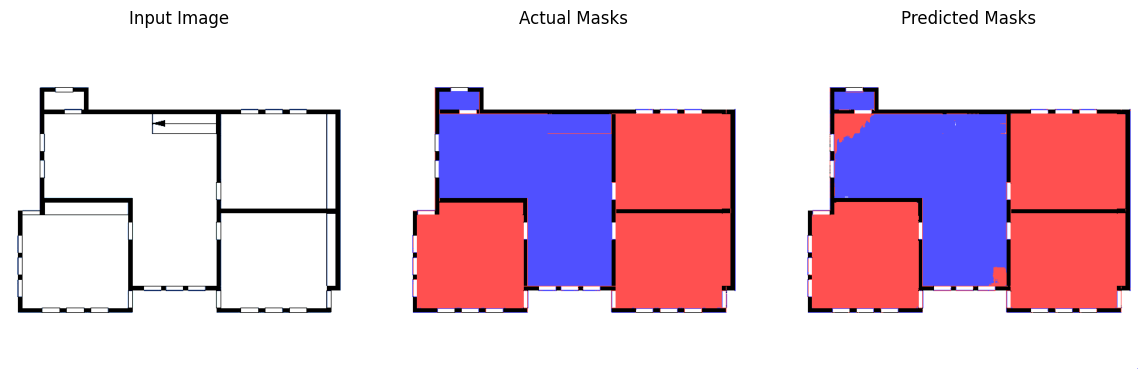

In [35]:
# Model-1

plot_segmentation(
    model=model1, 
    dataset=test_dataset, 
    color_mapping=color_mapping, 
    save_fig=True, 
    #save_root_dir='../generated_examples/', 
    save_root_dir = hyperparameters['output_dir']['results'],
    save_filename='model1_seg_fig', 
    save_format='png', 
    close_img=False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


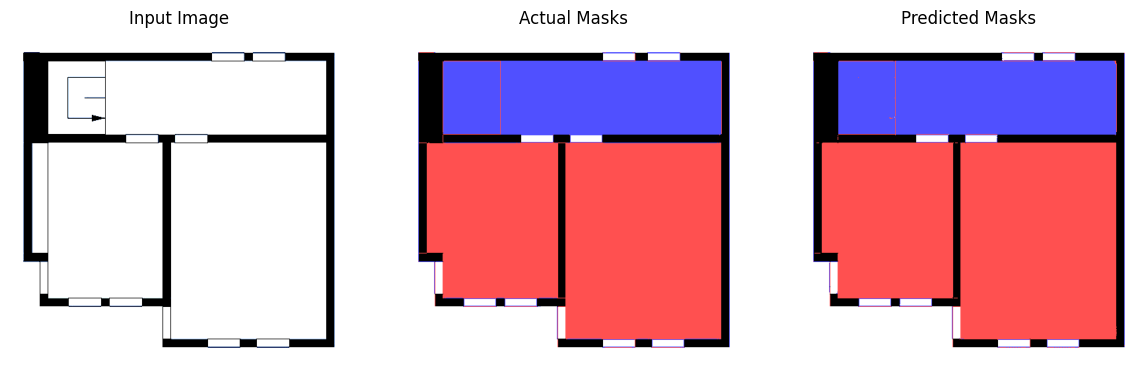

In [36]:
# Model-2

plot_segmentation(
    model=model2, 
    dataset=test_dataset, 
    color_mapping=color_mapping, 
    save_fig=True, 
    #save_root_dir='../generated_examples/', 
    save_root_dir = hyperparameters['output_dir']['results'],
    save_filename='model2_seg_fig', 
    save_format='png', 
    close_img=False
)

## Save Predictions

In [37]:
# Model1 Saving
save_pred_masks(
    model=model1,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model1'],
    input_folder='./images/test',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

save_pred_masks(
    model=model1,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model1'],
    input_folder='./images/train',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

In [38]:
# Model2 Saving
save_pred_masks(
    model=model2,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model2'],
    input_folder='./images/test',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

save_pred_masks(
    model=model2,
    transform=test_transforms,
    save_folder=hyperparameters['output_dir']['model2'],
    input_folder='./images/train',
    color_mapping=color_mapping,
    hyperparameters=hyperparameters,
)

## History Graphs

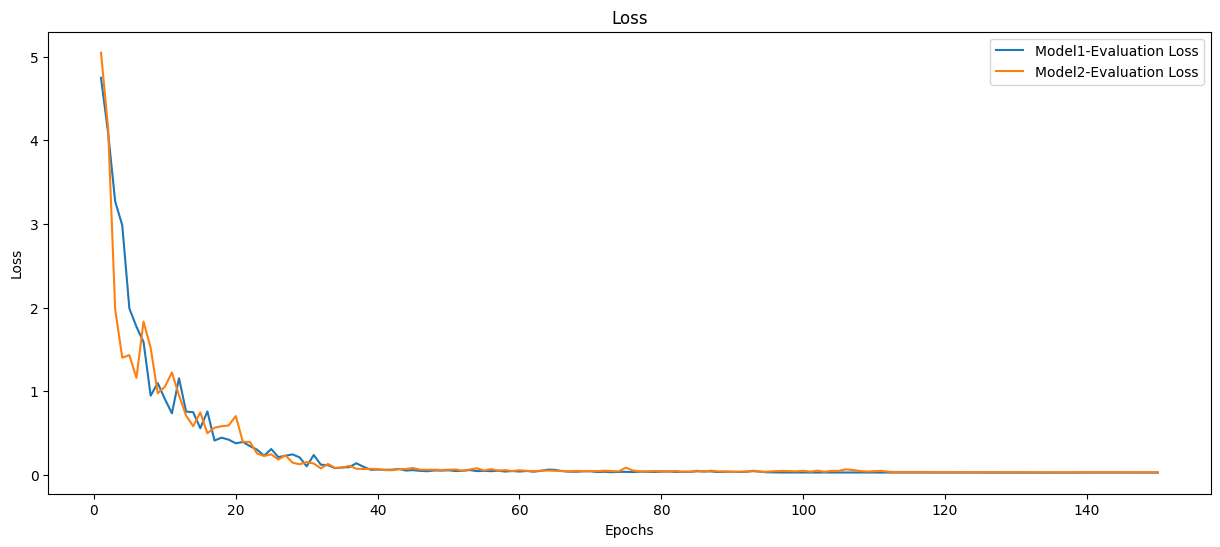

In [39]:
epoch_range = np.arange(1, hyperparameters['epochs']+1, 1, dtype=int)

plt.figure(figsize = (15,6))
plt.title(f"Loss")
plt.plot(epoch_range, history['model1']['eval_loss'], label="Model1-Evaluation Loss")
plt.plot(epoch_range, history['model2']['eval_loss'], label="Model2-Evaluation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
loss_dir = os.path.join(hyperparameters['output_dir']['results'], 'loss_graph.png')
plt.savefig(loss_dir, format='png', bbox_inches='tight')

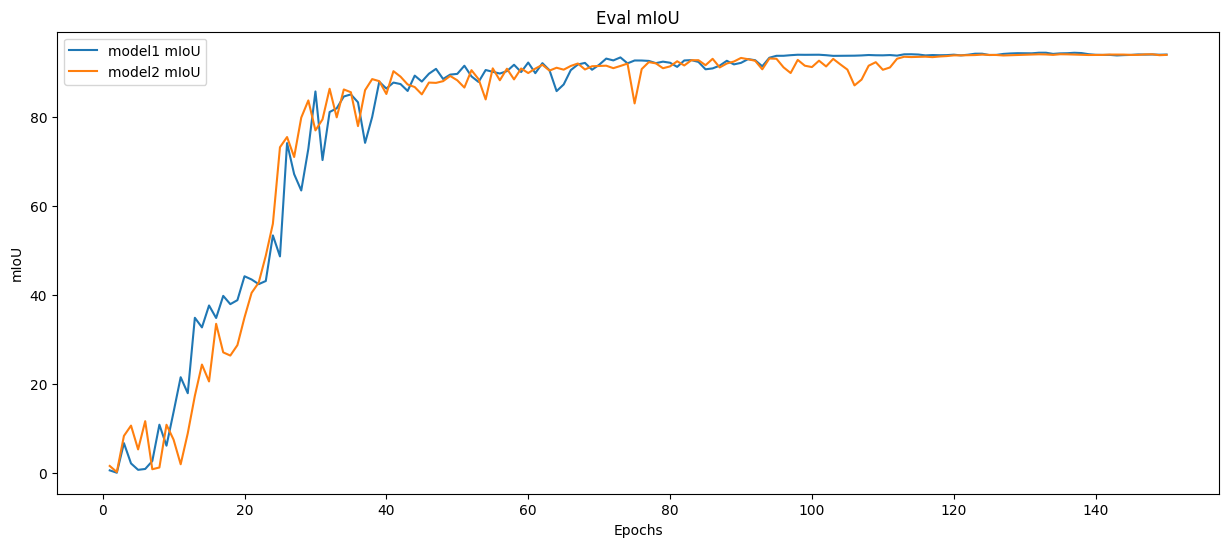

In [40]:
plt.figure(figsize = (15,6))
plt.title(f"Eval mIoU")
plt.plot(epoch_range, history['model1']['eval_miou'], label="model1 mIoU")
plt.plot(epoch_range, history['model2']['eval_miou'], label="model2 mIoU")
plt.xlabel("Epochs")
plt.ylabel("mIoU")
plt.legend();
miou_dir = os.path.join(hyperparameters['output_dir']['results'], 'miou_graph.png')
plt.savefig(miou_dir, format='png', bbox_inches='tight')

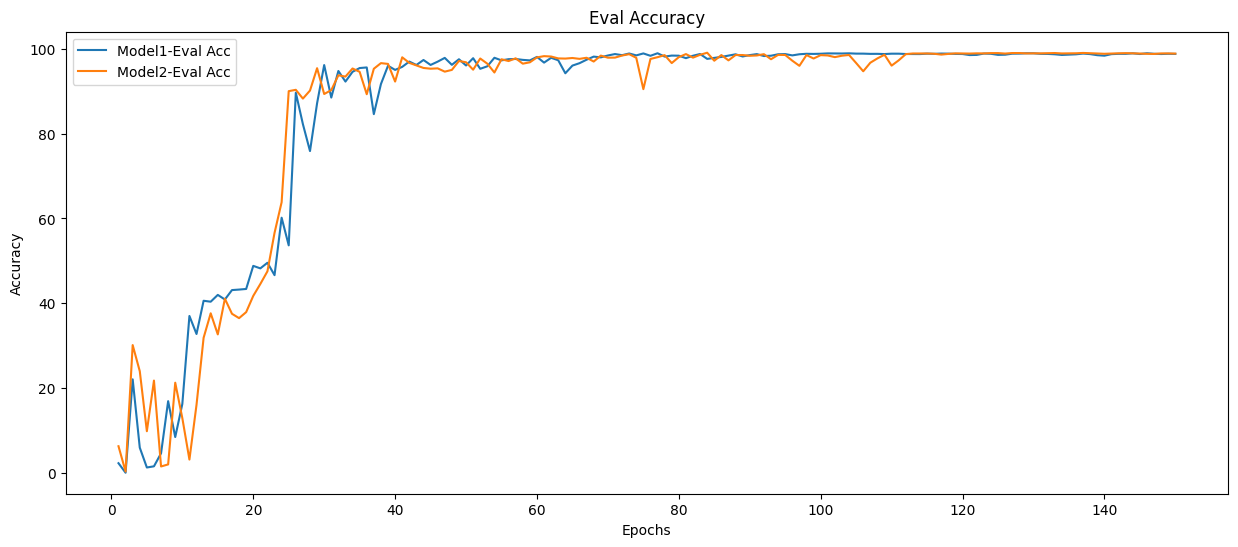

In [41]:
acc_tensor1 = torch.tensor(history['model1']['eval_acc'])
acc_tensor1 = acc_tensor1.to('cpu')
acc_list1 = acc_tensor1.tolist()

acc_tensor2 = torch.tensor(history['model2']['eval_acc'])
acc_tensor2 = acc_tensor2.to('cpu')
acc_list2 = acc_tensor2.tolist()

plt.figure(figsize = (15,6))
plt.title(f"Eval Accuracy")
plt.plot(epoch_range, acc_list1, label="Model1-Eval Acc")
plt.plot(epoch_range, acc_list2, label="Model2-Eval Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();
acc_dir = os.path.join(hyperparameters['output_dir']['results'], 'accuracy_graph.png')
plt.savefig(acc_dir, format='png', bbox_inches='tight')